In [57]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd

In [58]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
    layer.trainable = False
  
# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, 74, 74, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_282 (BatchN (None, 74, 74, 32)   96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, 74, 74, 32)   0           batch_normalization_282[0][0]    
_______________________________________________________________________________________

In [59]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [60]:
# # Define a Callback class that stops training once accuracy reaches 97.0%
# class myCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         if(logs.get('acc')>0.97):
#             print("\nReached 97.0% accuracy so cancelling training!")
#             self.model.stop_training = True
            

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.999):
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True
        

In [61]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, 74, 74, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_282 (BatchN (None, 74, 74, 32)   96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, 74, 74, 32)   0           batch_normalization_282[0][0]    
____________________________________________________________________________________________

In [62]:
# Define our example directories and files
train_dir = 'Dataset/train/'
validation_dir = 'Dataset/valid/'

train_horses_dir = os.path.join(train_dir, 'horses') # Directory with our training horse pictures
train_humans_dir = os.path.join(train_dir, 'humans') # Directory with our training humans pictures
validation_horses_dir = os.path.join(validation_dir, 'horses') # Directory with our validation horse pictures
validation_humans_dir = os.path.join(validation_dir, 'humans')# Directory with our validation humanas pictures

train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

print(len(train_horses_fnames))
print(len(train_humans_fnames))
print(len(validation_horses_fnames))
print(len(validation_humans_fnames))

500
527
128
128


In [63]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

# Expected Output:
# Found 1027 images belonging to 2 classes.
# Found 256 images belonging to 2 classes.

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [64]:
callbacks = myCallback()
history = model.fit_generator(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[callbacks]
)

# history = model.fit_generator(
#             train_generator,
#             validation_data = validation_generator,
#             steps_per_epoch = 100,
#             epochs = 100,
#             validation_steps = 50,
#             verbose = 2,
#             callbacks=[callbacks])


Epoch 1/100
52/52 [==============================] - 31s 601ms/step - loss: 0.1588 - acc: 0.9455 - val_loss: 0.0176 - val_acc: 0.9922
Epoch 2/100
52/52 [==============================] - 30s 572ms/step - loss: 0.0343 - acc: 0.9922 - val_loss: 0.0453 - val_acc: 0.9844
Epoch 3/100
52/52 [==============================] - 31s 592ms/step - loss: 0.0154 - acc: 0.9971 - val_loss: 0.1635 - val_acc: 0.9609
Epoch 4/100
52/52 [==============================] - 29s 560ms/step - loss: 0.0213 - acc: 0.9912 - val_loss: 0.3273 - val_acc: 0.9453
Epoch 5/100
52/52 [==============================] - 29s 564ms/step - loss: 0.0128 - acc: 0.9951 - val_loss: 0.1373 - val_acc: 0.9688
Epoch 6/100
52/52 [==============================] - 29s 551ms/step - loss: 0.0178 - acc: 0.9932 - val_loss: 0.0296 - val_acc: 0.9883
Epoch 7/100
52/52 [==============================] - 31s 604ms/step - loss: 0.0181 - acc: 0.9951 - val_loss: 0.0210 - val_acc: 0.9922
Epoch 8/100
52/52 [==============================] - 31s 598ms

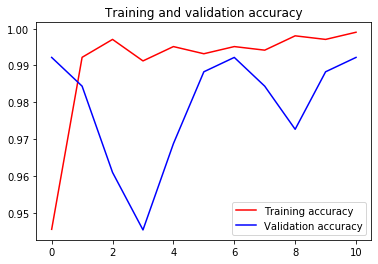

<Figure size 432x288 with 0 Axes>

In [66]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()